Libraries Used

In [7]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [8]:
import numpy as np
import scipy
import pandas as pd
import datetime
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm
import cartopy.feature as cfeature

from datetime import timedelta

import imageio

from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator

#### Helper Functions:
Load all

In [9]:
data_folder = '/Users/dlugardo/Desktop/data/ENU_v2' # path to the folder with the data 

def get_data(location):
    file_name = str(location) + '.ENU.txt'
    path = os.path.join(data_folder, file_name)

    if os.path.isfile(path):
        data = np.loadtxt(path, skiprows=2)
    else:
        file_name = str(location) + '_ENU.txt'
        path = os.path.join(data_folder, file_name)

        if os.path.isfile(path):
            data = np.loadtxt(path, skiprows=2)
        else:
            raise FileNotFoundError(f"Neither '{location}.ENU.txt' nor '{location}_ENU.txt' found in {data_folder}")
    return data

In [10]:
def decimal_year_to_date(decimal_year):
    """
    Converts a decimal year to a datetime.date object.
    """
    year = int(decimal_year)
    fractional_part = decimal_year - year

    # Determine if it's a leap year for accurate day calculation
    is_leap = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    days_in_year = 366 if is_leap else 365

    # Calculate the number of days from the start of the year
    days_offset = fractional_part * days_in_year

    # Create a datetime object for January 1st of that year
    start_of_year = datetime.date(year, 1, 1)

    # Add the calculated offset in days
    result_date = start_of_year + datetime.timedelta(days=days_offset)

    return result_date


In [11]:
def doy_to_angle(doy):
    radians = doy * 2 * np.pi / 365
    mean_angle = np.arctan2(np.mean(np.sin(radians)), np.mean(np.cos(radians)))
    cos = np.cos(mean_angle)
    return(cos)

In [12]:
def circular_mean(doys):
    radians = doys * 2 * np.pi / 365
    mean_angle = np.arctan2(np.mean(np.sin(radians)), np.mean(np.cos(radians)))
    mean_doy = (mean_angle * 365 / (2 * np.pi)) % 365
    return round(mean_doy)

In [13]:
MAX_GAP_DAYS = 14 

def find_longest_continuous_segment(dates, max_gap_days=14):
    # Ensure dates are sorted
    dates = np.sort(dates)
    segments = []
    current_segment = [dates[0]]

    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days <= max_gap_days:
            current_segment.append(dates[i])
        else:
            segments.append(current_segment)
            current_segment = [dates[i]]
    segments.append(current_segment)

    # Return the longest continuous segment
    return max(segments, key=len)

In [14]:
StationMetaData = df = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/GreenlandStations.csv')
StationMetaData

,station,latitude,longitude,elevation_m,is_greenland
0,NGFJ,80.568475,-16.841131,35.5,True
1,JWLF,83.111656,-45.119847,112.9,True
2,THU4,76.537106,-68.824953,36.2,True
3,JGBL,82.208758,-31.004208,753.3,True
4,THU2,76.537047,-68.825050,36.2,True
...,...,...,...,...,...
71,MIK2,68.140281,-31.451825,815.9,True
72,KUAQ,68.587000,-33.052750,865.2,True
73,KSUT,64.070697,-52.007697,40.7,True
74,RINK,71.848500,-50.993967,1337.9,True


### Specific Tasks
## Long Term Mean CSV creation

In [ ]:
## LTM Creation
from datetime import timedelta

stations_names_with_data = []
metadata_records = []

MAX_GAP_DAYS = 14  # maximum acceptable gap (in days)


for station_name in StationMetaData.station:
    try:
        raw_data = get_data(station_name)
        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])

        # Find longest continuous segment of data
        continuous_segment = find_longest_continuous_segment(converted_dates, max_gap_days=MAX_GAP_DAYS)

        if len(continuous_segment) < 365 * 5:  # optional: skip if segment is too short
            print(f"  → Skipping {station_name}: continuous segment too short.")
            continue

        # Filter both data and error to this segment
        mask = np.isin(converted_dates, continuous_segment)
        data = raw_data[mask, 1:4]
        error = raw_data[mask, 4:]
        converted_dates = converted_dates[mask]
        
        # Detrend data
        data_detrended = scipy.signal.detrend(data, axis=0)

        # Build DataFrame
        df = pd.DataFrame({'time': converted_dates})
        df['east'] = data_detrended[:, 0]
        df['north'] = data_detrended[:, 1]
        df['up'] = data_detrended[:, 2]
        df.set_index('time', inplace=True)

        # Compute monthly climatology
        df['month_day'] = df.index.map(lambda x: x.strftime('%m-%d'))
        df = df[df['month_day'] != '02-29']
        climatology_daily = df.groupby('month_day')[['east', 'north', 'up']].mean()
    
        climatology_daily.to_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station_name + '_DailyLTM.csv', index = True) 
        
        start_date = continuous_segment[0]
        end_date = continuous_segment[-1]
        duration_years = round((end_date - start_date).days / 365.25, 2)

        metadata_records.append({
            'station': station_name,
            'start_date': start_date.strftime('%Y-%m-%d'),
            'end_date': end_date.strftime('%Y-%m-%d'),
            'years_of_data': duration_years
        })

        stations_names_with_data.append(station_name)

    except FileNotFoundError:
        print(f"  → File not found for station {station_name}. Skipping.")
        continue
    except Exception as e:
        print(f"  → Error processing station {station_name}: {e}")
        continue

#metadata_df = pd.DataFrame(metadata_records)
#metadata_df.to_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/LTM_station_metadata.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

stations_names_with_data = []
metadata_records = []

MAX_GAP_DAYS = 14  # maximum acceptable gap (in days)
INTERP_LIMIT = 5   # max interpolation gap in days
wdays = 30

for station_name in StationMetaData.station:
    try:
        raw_data = get_data(station_name)
        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])

        # Find longest continuous segment of data
        continuous_segment = find_longest_continuous_segment(
            converted_dates, max_gap_days=MAX_GAP_DAYS
        )

        if len(continuous_segment) < 365 * 3:  # optional: skip if segment is too short
            print(f"  → Skipping {station_name}: continuous segment too short.")
            continue

        # Filter both data and error to this segment
        mask = np.isin(converted_dates, continuous_segment)
        data = raw_data[mask, 1:4]
        error = raw_data[mask, 4:]
        converted_dates = converted_dates[mask]

        # Detrend data
        data_detrended = scipy.signal.detrend(data, axis=0)

        # Build DataFrame
        df = pd.DataFrame({'time': converted_dates})
        df['time'] = pd.to_datetime(df['time'])
        df['east'] = data_detrended[:, 0]
        df['north'] = data_detrended[:, 1]
        df['up'] = data_detrended[:, 2]
        df.set_index('time', inplace=True)

        # Rolling average
        df_rolling = df.rolling(window=wdays, center=True, min_periods=wdays).mean()
        df_rolling = df_rolling.dropna()

        # --- NEW SECTION: ensure full daily coverage with interpolation ---
        df_rolling['year'] = df_rolling.index.year
        df_rolling['doy'] = df_rolling.index.dayofyear

        filled_list = []
        for year, group in df_rolling.groupby('year'):
            # always use DOY 1–365 (skip leap day)
            full_range = pd.DataFrame({'doy': np.arange(1, 366)})
            full_range['year'] = year

            # merge to get missing days as NaN
            group = full_range.merge(group, on=['year', 'doy'], how='left')

            # restore datetime index
            group['time'] = pd.to_datetime(
                group['year'].astype(str) + '-' + group['doy'].astype(str),
                format='%Y-%j',
                errors='coerce'
            )

            group = group.set_index('time').sort_index()

            # interpolate only small gaps
            for col in ['east', 'north', 'up']:
                group[col] = group[col].interpolate(
                    method="linear", limit=INTERP_LIMIT, limit_direction="both"
                )

            filled_list.append(group)

        df_rolling = pd.concat(filled_list).sort_index()
        # ---------------------------------------------------------------

        # Remove leap day explicitly if it sneaks in
        df_rolling = df_rolling[df_rolling.index.strftime('%m-%d') != '02-29']

        # Compute daily climatology (LTM)
        df_rolling['month_day'] = df_rolling.index.strftime('%m-%d')
        climatology_daily = df_rolling.groupby('month_day')[['east', 'north', 'up']].mean()
        stds = df_rolling.groupby('month_day')[['east', 'north', 'up']].std()
        
        stds.columns = ['east_sd', 'north_sd', 'up_sd']
        climatology_daily = climatology_daily.join(stds)

        # Save LTM for this station
        climatology_daily.to_csv(
            f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/{station_name}_Daily{wdays}RollingLTM.csv',
            index=True
        )

        stations_names_with_data.append(station_name)

    except FileNotFoundError:
        print(f"  → File not found for station {station_name}. Skipping.")
        continue
    except Exception as e:
        print(f"  → Error processing station {station_name}: {e}")
        continue


  → Skipping NGFJ: continuous segment too short.
  → File not found for station THU4. Skipping.
  → File not found for station QENU. Skipping.
  → File not found for station AAS2. Skipping.
  → Skipping EQNU: continuous segment too short.
  → Skipping SCOB: continuous segment too short.
  → File not found for station SCO4. Skipping.
  → File not found for station STNO. Skipping.
  → File not found for station QAQ2. Skipping.
  → File not found for station KLQ3. Skipping.
  → Skipping UPAK: continuous segment too short.
  → Skipping AVAN: continuous segment too short.
  → Skipping THU1: continuous segment too short.
  → File not found for station THU3. Skipping.
  → Skipping NUNA: continuous segment too short.
  → File not found for station KSUT. Skipping.


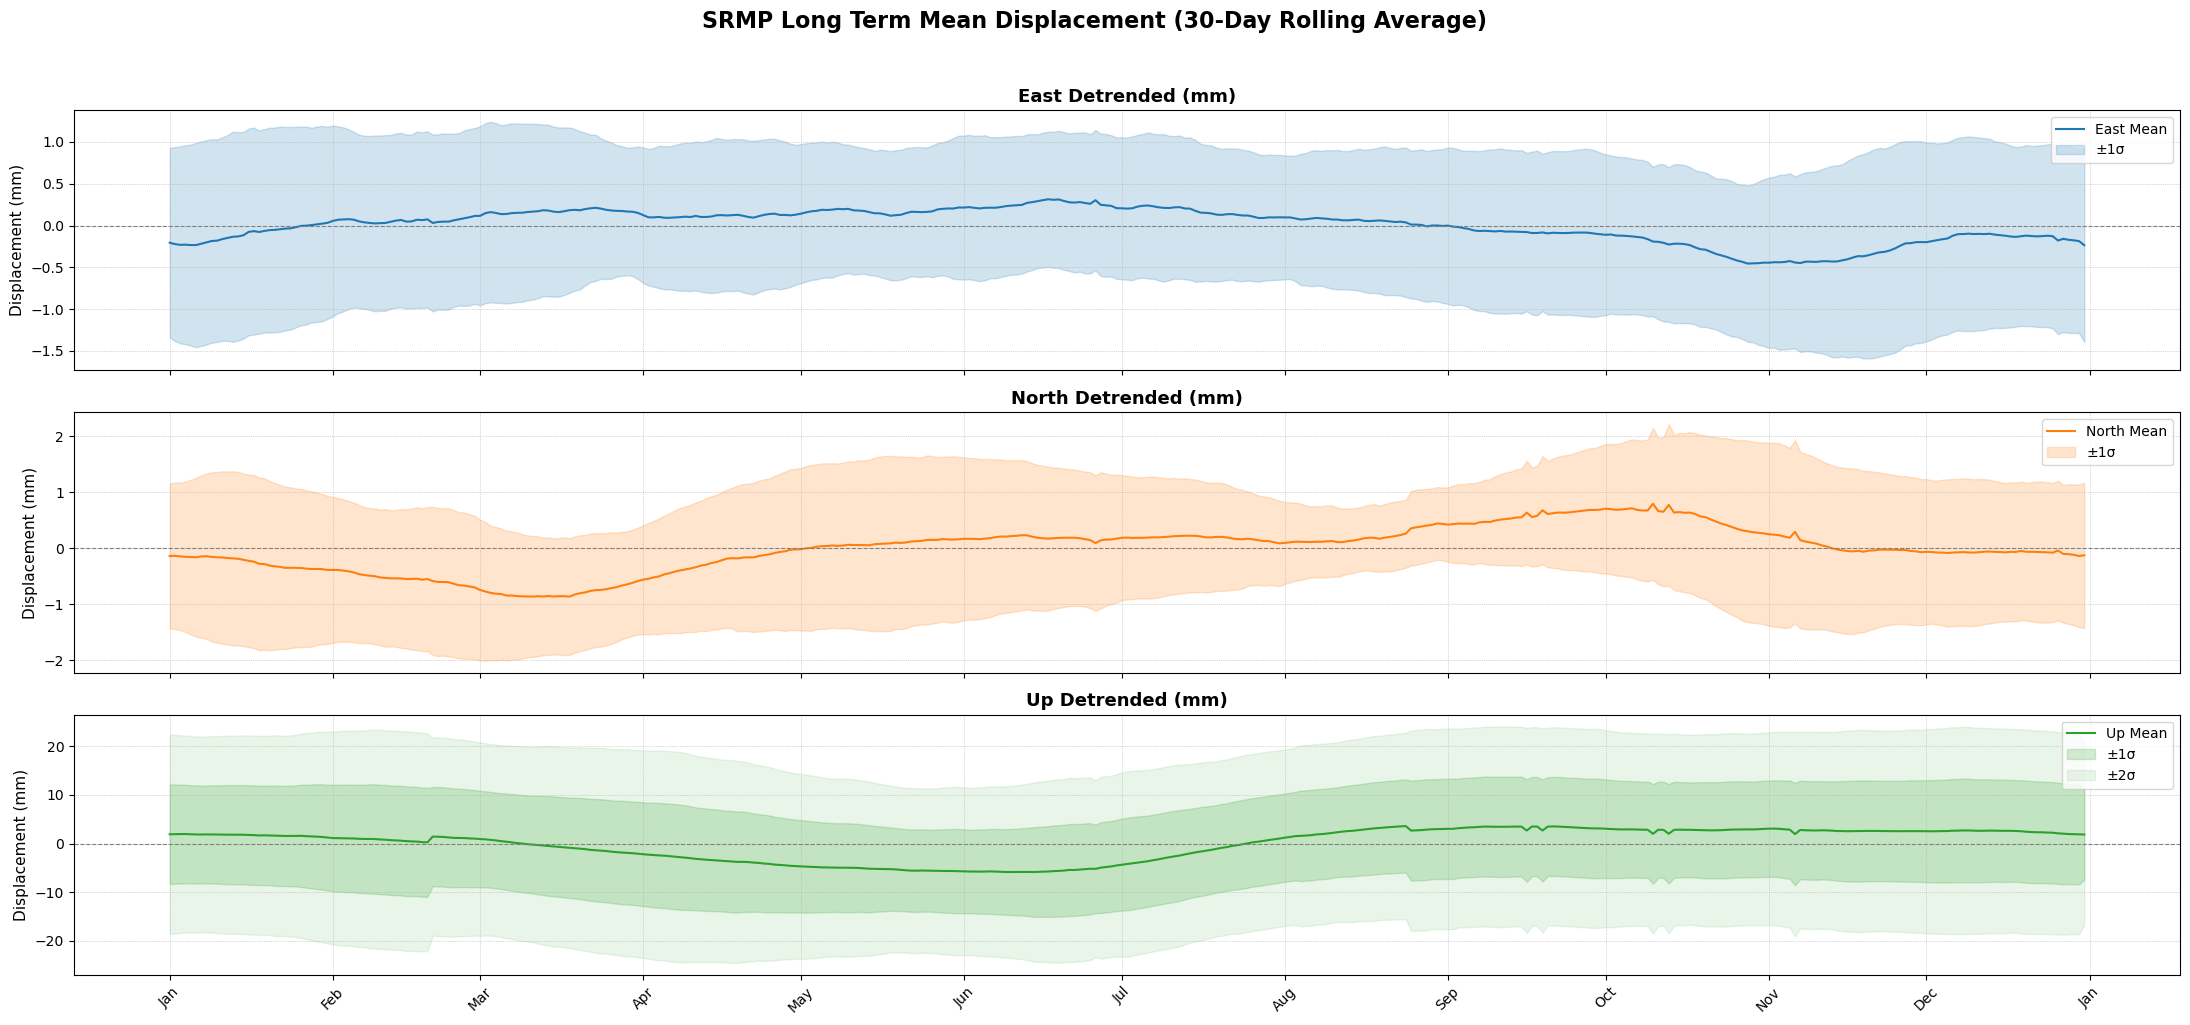

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
station = 'SRMP'
climatology_daily = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_Daily30RollingLTM.csv') # ',{station_name}_Daily{wdays}RollingLTM.csv

# Set up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(22, 10), sharex=True)

# Define colors
colors = {'east': '#1f77b4', 'north': '#ff7f0e', 'up': '#2ca02c'}

# Plot each component
components = ['east', 'north', 'up']
titles = ['East Detrended (mm)', 'North Detrended (mm)', 'Up Detrended (mm)']

for i, component in enumerate(components):
    ax = axs[i]
    sd = climatology_daily[component + '_sd']
    ax.plot(climatology_daily['month_day'], climatology_daily[component], label=f'{component.title()} Mean', color=colors[component])
    ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')

    # 1-sigma shading
    ax.fill_between(climatology_daily['month_day'],
                    climatology_daily[component] - sd,
                    climatology_daily[component] + sd,
                    color=colors[component], alpha=0.2, label='±1σ')

    # 2-sigma only for 'up'
    if component == 'up':
        ax.fill_between(climatology_daily['month_day'],
                        climatology_daily[component] - 2 * sd,
                        climatology_daily[component] + 2 * sd,
                        color=colors[component], alpha=0.1, label='±2σ')

    ax.set_title(titles[i], fontsize=13, weight='bold')
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_ylabel('Displacement (mm)', fontsize=11)

# X-axis settings
#axs[-1].set_xlabel('Date (MM-DD)', fontsize=12)
axs[-1].xaxis.set_major_locator(mdates.MonthLocator())
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Rotate x labels
plt.setp(axs[-1].xaxis.get_majorticklabels(), rotation=45)

# Add overall title
fig.suptitle(f'{station} Long Term Mean Displacement (30-Day Rolling Average)', fontsize=16, weight='bold', y=1.02)

# Final layout tweaks
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## Animation of Vectors

In [ ]:
Time_days =  pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_DailyLTM.csv').month_day

cmap = cm.coolwarm_r
vmin = -8  # or use np.nanmin of all station 'up' values if precomputed
vmax = 8   # same as above
norm = colors.Normalize(vmin=vmin, vmax=vmax)

filenames = []  

for n, month_day in enumerate(Time_days):
    fig= plt.figure(figsize=(8,11))
    ax = plt.axes(projection=ccrs.Stereographic())
    plt.title("Deterended LTM Daily Average Station Displacement Vectors  " + str(month_day))

    ax.set_extent([-55, -5, 55, 90])
    ax.gridlines(draw_labels=True)
    ax.stock_img()
    ax.coastlines(resolution='10m', alpha = 0.3)

    for station in stations_names_with_data:
        climatology_daily = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_DailyLTM.csv')
        
        smdt = StationMetaData.loc[StationMetaData['station'] == station]

        lon = smdt.longitude
        lat = smdt.latitude

        ax.plot(lon, lat, marker='o', color='black', markersize=2, alpha=0.6, transform=ccrs.Geodetic())
        
        U = np.array([climatology_daily['east'].iloc[n]])
        V = np.array([climatology_daily['north'].iloc[n]])
        C = np.array(climatology_daily['up'].iloc[n]) 

        scale_factor = 12

        ax.quiver(
            lon, lat, U , V ,
            [C],  # color mapped by vertical component
            scale=scale_factor,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            width=0.005,
            alpha=1,
            edgecolor='k',
            linewidth=0.5,
            headwidth=2,         # smaller width
            headlength=2,        # smaller length
            headaxislength=2.5)
            
        magnitude = np.sqrt(U**2 + V**2)
        #print(f"{station} @ {month}: U={U}, V={V}, Mag={magnitude}")


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # only needed for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.02)
    cbar.set_label('Vertical Displacement (mm)')


    ref_mm = 1  # reference displacement in mm
    ref_units = ref_mm  # length in plot units

    Q = ax.quiver(
        np.array([0]), np.array([0]),
        np.array([1]), np.array([0]),
        transform=ccrs.PlateCarree(),
        scale=scale_factor,
    )

    ax.quiverkey(
        Q,
        X=0.55, Y=-0.1, U=ref_units,
        label=f'{ref_mm} mm',
        labelpos='E',
        coordinates='axes'
    )

    plt.tight_layout()
    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/LTM_MapVis_{month_day}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily.gif', mode='I', duration=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily.mp4' , fps=12) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        

### Rolling Average

In [ ]:
Time_days =  pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_DailyLTM.csv').month_day

cmap = cm.coolwarm_r
vmin = -7  # or use np.nanmin of all station 'up' values if precomputed
vmax = 7   # same as above
norm = colors.Normalize(vmin=vmin, vmax=vmax)

filenames = []  

for n, month_day in enumerate(Time_days):
    fig= plt.figure(figsize=(8,11))
    ax = plt.axes(projection=ccrs.Stereographic())
    plt.title("Deterended LTM Daily Average (15 Days Rolled Average) Displacement " + str(month_day))

    ax.set_extent([-55, -5, 55, 90])
    ax.gridlines(draw_labels=True)
    ax.stock_img()
    ax.coastlines(resolution='10m', alpha = 0.3)

    for station in stations_names_with_data:
        climatology_daily = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_Daily15RollingLTM.csv')
        smdt = StationMetaData.loc[StationMetaData['station'] == station]

        lon = smdt.longitude
        lat = smdt.latitude

        ax.plot(lon, lat, marker='o', color='black', markersize=2, alpha=0.6, transform=ccrs.Geodetic())
        
        U = np.array([climatology_daily['east'].iloc[n]])
        V = np.array([climatology_daily['north'].iloc[n]])
        C = np.array(climatology_daily['up'].iloc[n]) 

        scale_factor = 12

        ax.quiver(
            lon, lat, U , V ,
            [C],  # color mapped by vertical component
            scale=scale_factor,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            width=0.005,
            alpha=1,
            edgecolor='k',
            linewidth=0.5,
            headwidth=2,         # smaller width
            headlength=2,        # smaller length
            headaxislength=2.5
        )
        magnitude = np.sqrt(U**2 + V**2)
        #print(f"{station} @ {month}: U={U}, V={V}, Mag={magnitude}")


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # only needed for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.02)
    cbar.set_label('Vertical Displacement (mm)')


    ref_mm = 1  # reference displacement in mm
    ref_units = ref_mm  # length in plot units

    Q = ax.quiver(
        np.array([0]), np.array([0]),
        np.array([1]), np.array([0]),
        transform=ccrs.PlateCarree(),
        scale=scale_factor,
    )

    ax.quiverkey(
        Q,
        X=0.55, Y=-0.1, U=ref_units,
        label=f'{ref_mm} mm',
        labelpos='E',
        coordinates='axes'
    )

    plt.tight_layout()
    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/LTM_MapVis_{month_day}_15Rolling.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily15Rolling.gif', mode='I', duration=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Daily15Rolling.mp4' , fps=12) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        

## Overplotting Every Year for a Station

In [37]:
station_name = 'SRMP'

raw_data = get_data(station_name)
time = raw_data[:, 0]
converted_dates = np.array([decimal_year_to_date(dy) for dy in time])
data = raw_data[:, 1:4]
error = raw_data[:, 4:]

# Detrend data
data_detrended = scipy.signal.detrend(data, axis=0)

# Build DataFrame
df = pd.DataFrame({'time': converted_dates})
df['east'] = data_detrended[:, 0]
df['north'] = data_detrended[:, 1]
df['up'] = data_detrended[:, 2]
df.set_index('time', inplace=True)

df_rolling = df.rolling(window=30, center=True, min_periods=30).mean()
df_rolling['year'] = df_rolling.index.map(lambda x: x.strftime('%y'))
df_rolling.index = pd.to_datetime(df_rolling.index)
df_rolling['doy'] = df_rolling.index.dayofyear
df_rolling

,east,north,up,year,doy
time,,,,,
2007-08-13,NaN,NaN,NaN,07,225
2007-08-14,NaN,NaN,NaN,07,226
2007-08-15,NaN,NaN,NaN,07,227
2007-08-16,NaN,NaN,NaN,07,228
2007-08-17,NaN,NaN,NaN,07,229
...,...,...,...,...,...
2025-02-26,NaN,NaN,NaN,25,57
2025-02-27,NaN,NaN,NaN,25,58
2025-02-28,NaN,NaN,NaN,25,59


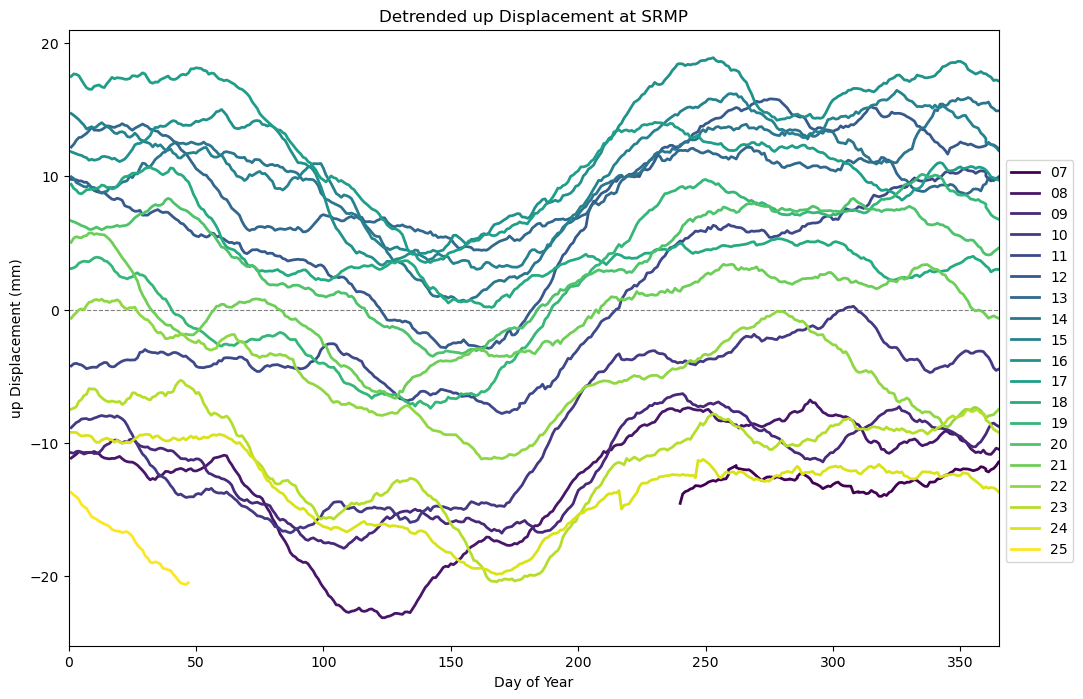

In [38]:
fig= plt.figure(figsize=(12,8))

years = sorted(np.unique(df_rolling.year))
col  = cm.get_cmap('viridis', len(years))

Disp = 'up'
station_name = 'SRMP'

peak, minima, amplitude, years_used, filenames = [],[], [], [], []
plt.xlabel('Day of Year')
plt.ylabel( Disp + ' Displacement (mm)')
plt.title('Detrended ' + Disp + ' Displacement at ' + station_name)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlim(0, 365)


for i, year in enumerate(np.unique(df_rolling.year)):
    data = df_rolling[df_rolling['year'] == str(year)]

    if data.shape[0] > 350:
        years_used.append(str(year))
        a = data[Disp].idxmin()
        minima.append(data['doy'][a])

        b = data[Disp].idxmax()
        peak.append(data['doy'][b])

        a1 = data[Disp].min()
        b1 = data[Disp].max()
        amplitude.append(b1-a1)

    plt.plot(data['doy'], data[Disp], label = year, color = col(i), lw = 2)
    plt.legend(bbox_to_anchor=(1, 0.8))
    filename = ('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det'+ Disp + 'Disp_' + station_name + '_' + str(year) + '.png')
    plt.savefig(filename)
    filenames.append(filename)
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Det'+Disp+'Disp_' + station_name + '.gif', mode='I', duration=150.0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

peak = np.array(peak)
minima = np.array(minima)
amplitude = np.array(amplitude)
years_used = np.array(years_used)

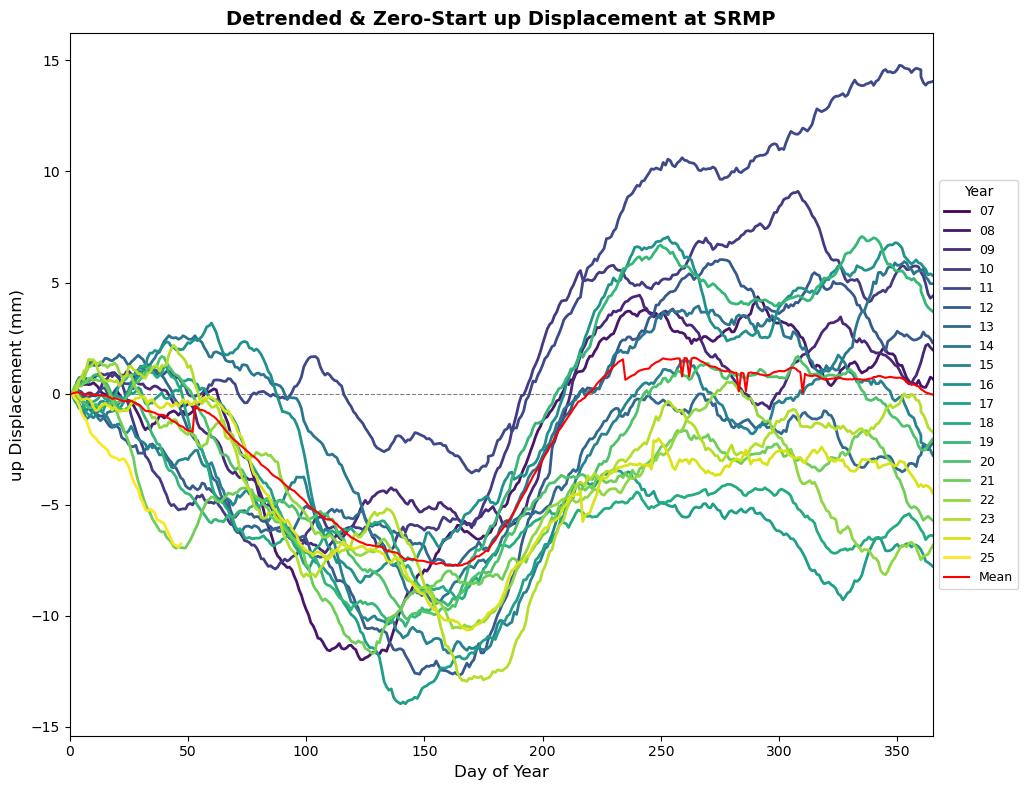

In [39]:
fig = plt.figure(figsize=(12, 8))
filenames = []

years = sorted(np.unique(df_rolling.year))
colormap = cm.get_cmap('viridis', len(years))

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(Disp + ' Displacement (mm)', fontsize=12)
plt.title(f'Detrended & Zero-Start {Disp} Displacement at {station_name}', fontsize=14, weight='bold')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlim(0, 365)

for i, year in enumerate(years):
    data = df_rolling[df_rolling['year'] == str(year)]

    offset_up = data[Disp] - data[Disp].iloc[0]
    plt.plot(data['doy'], offset_up, label=str(year), color=colormap(i), lw=2)
    
    plt.legend(title="Year", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det0{Disp}Disp_{station_name}_{year}.png'
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(filename, dpi=150)
    filenames.append(filename)

data = df_rolling[df_rolling['year'] == '22']
LTM = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_Daily30RollingLTM.csv')
offset_up_LTM = LTM[Disp] - LTM[Disp].iloc[0]
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.plot(data['doy'], offset_up_LTM, label = 'Mean', c= 'red')
plt.legend(title="Year", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det0{Disp}Disp_{station_name}_Mean.png'
plt.savefig(filename, dpi=150)
filenames.append(filename)


gif_path = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Det0{Disp}Disp_{station_name}.gif'
with imageio.get_writer(gif_path, mode='I', duration=200) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

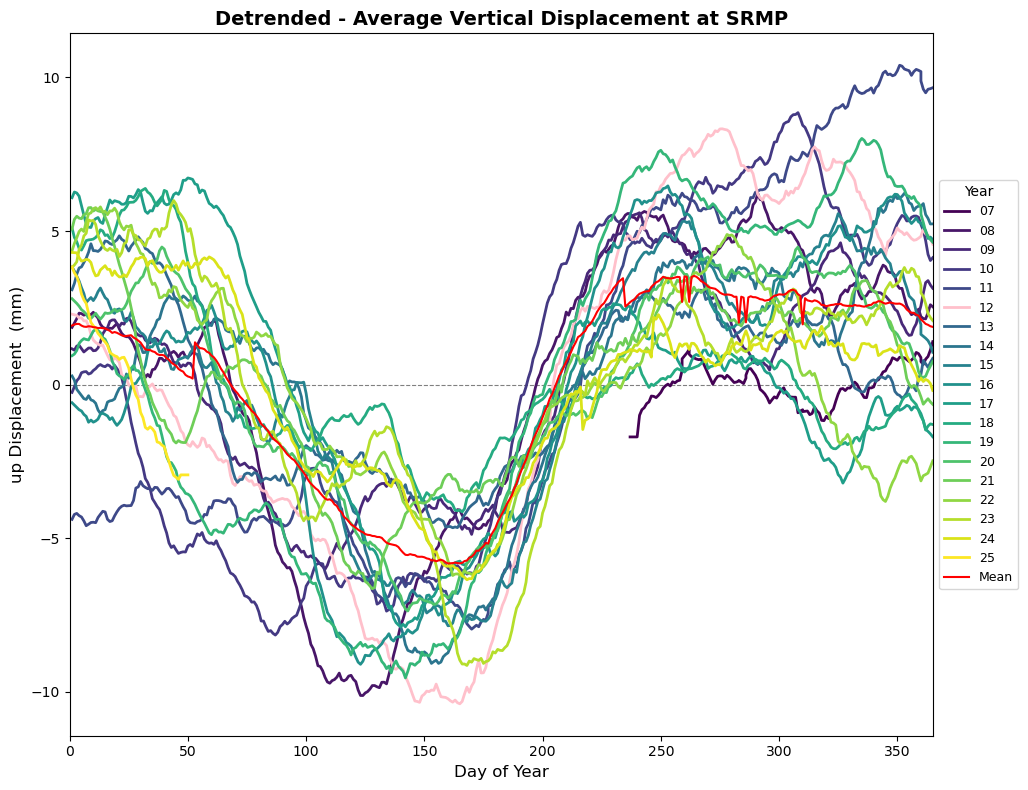

In [40]:
fig = plt.figure(figsize=(12, 8))
filenames = []

years = sorted(np.unique(df_rolling.year))
colormap = cm.get_cmap('viridis', len(years))

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(Disp + ' Displacement  (mm)', fontsize=12)
plt.title(f'Detrended - Average Vertical Displacement at {station_name}', fontsize=14, weight='bold')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlim(0, 365)

for i, year in enumerate(years):
    data = df_rolling[df_rolling['year'] == str(year)]

    full_range = pd.DataFrame({'doy': np.arange(1, 366)})
    data = full_range.merge(data, on="doy", how="left")
    data['year'] = str(year)
    data[Disp] = data[Disp].interpolate(method="linear", limit=3, limit_direction="both")

    avg = np.nanmean(data[Disp])
    offset = data[Disp] - avg

    if year == '12':
        co = 'pink'
    else:
        co = colormap(i)
    plt.plot(data['doy'], offset, label=str(year), color=co, lw=2)
    
    plt.legend(title="Year", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Det0{Disp}Disp_{station_name}_{year}.png'
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(filename, dpi=150)
    filenames.append(filename)

data = df_rolling[df_rolling['year'] == '22']
LTM = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/SRMP_Daily30RollingLTM.csv')
offset_LTM = LTM[Disp] - np.mean(LTM[Disp])
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.plot(data['doy'], offset_LTM, label = 'Mean', c= 'red')
plt.legend(title="Year", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/Compressed{Disp}Disp_{station_name}_Mean.png'
plt.savefig(filename, dpi=150)
filenames.append(filename)

gif_path = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/Compressed{Disp}Disp_{station_name}.gif'
with imageio.get_writer(gif_path, mode='I', duration=200) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

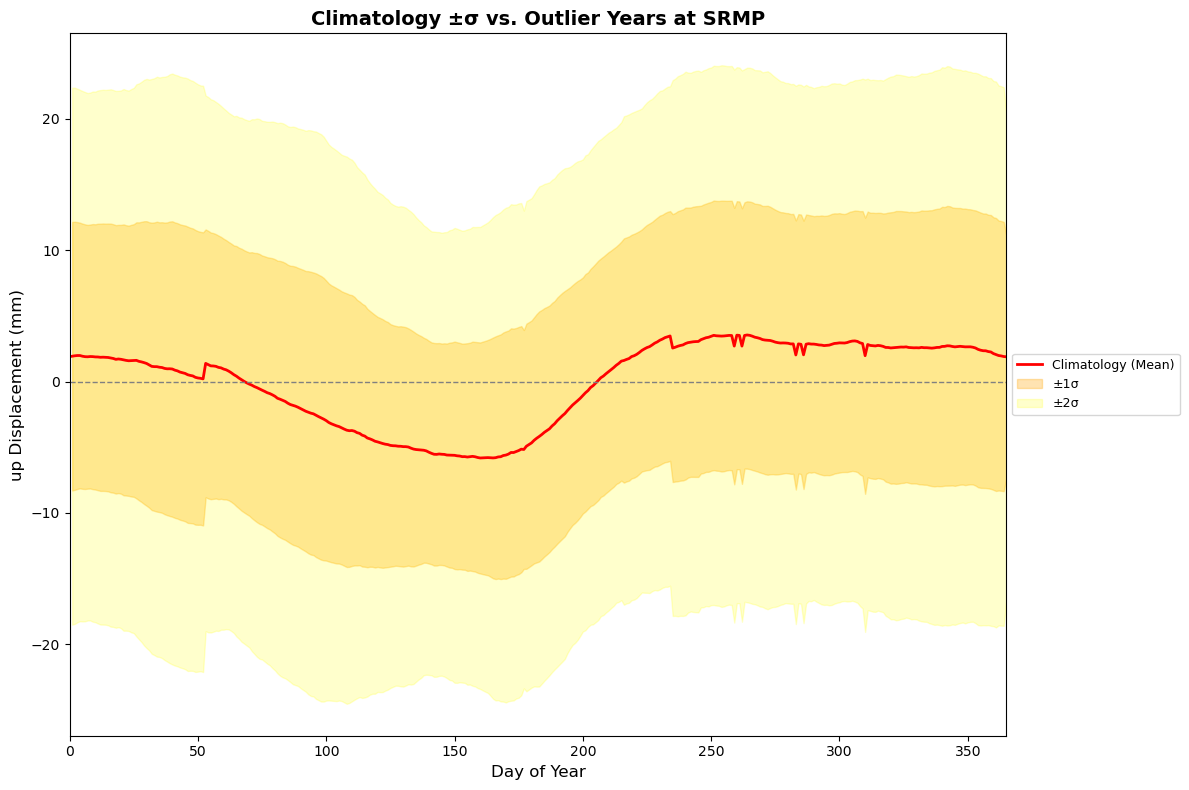

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Load LTM ---
LTM = pd.read_csv(
    f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/{station_name}_Daily{wdays}RollingLTM.csv')

# Ensure month_day column exists (depends on how LTM was saved)
if "month_day" not in LTM.columns:
    LTM = LTM.reset_index().rename(columns={"Unnamed: 0": "month_day"})

# Extract climatology mean and stdev
clim = LTM[Disp].values
std1 = LTM[f"{Disp}_sd"].values

# Mean ± 1σ and ± 2σ
upper1, lower1 = clim + std1, clim - std1
upper2, lower2 = clim + 2 * std1, clim - 2 * std1

days = np.arange(1, len(LTM) + 1)   # should be 365 rows normally

# --- Plot base climatology ---
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(days, clim - np.nanmean(clim), color="red", lw=2, label="Climatology (Mean)")

ax.fill_between(days, lower1 - np.nanmean(clim), upper1 - np.nanmean(clim),
                color="orange", alpha=0.3, label="±1σ")

ax.fill_between(days, lower2 - np.nanmean(clim), upper2 - np.nanmean(clim),
                color="yellow", alpha=0.2, label="±2σ")

# --- Overlay anomalous years ---
years = sorted(df_rolling['year'].unique())
colormap = cm.get_cmap('tab10', len(years))  # distinct colors

for i, year in enumerate(years):
    data = df_rolling[df_rolling['year'] == year].copy()
    data['month_day'] = data.index.strftime('%m-%d')
    data['doy'] = data.index.dayofyear

    # Merge with climatology
    merged = data.merge(LTM[['month_day', Disp, f"{Disp}_sd"]], on="month_day", how="inner")

    # Offset by year’s mean
    offset = merged[Disp + "_x"] - np.nanmean(merged[Disp + "_x"])

    # Climatology reference for these DOYs
    clim_mean = merged[Disp + "_y"] - np.nanmean(clim)
    clim_upper2 = merged[Disp + "_y"] + 1.5 * merged[f"{Disp}_sd"] - np.nanmean(clim)
    clim_lower2 = merged[Disp + "_y"] - 1.5 * merged[f"{Disp}_sd"] - np.nanmean(clim)

    # If any value outside ±2σ, plot the whole year
    if np.any((offset > clim_upper2) | (offset < clim_lower2)):
        ax.plot(merged['doy'], offset, lw=1.8, color=colormap(i), label=str(year))

# --- Final styling ---
ax.axhline(0, color="gray", linestyle="--", lw=1)
ax.set_xlim(0, 365)
ax.set_xlabel("Day of Year", fontsize=12)
ax.set_ylabel(f"{Disp} Displacement (mm)", fontsize=12)
ax.set_title(f"Climatology ±σ vs. Outlier Years at {station_name}",
             fontsize=14, weight="bold")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)

plt.tight_layout()
plt.show()


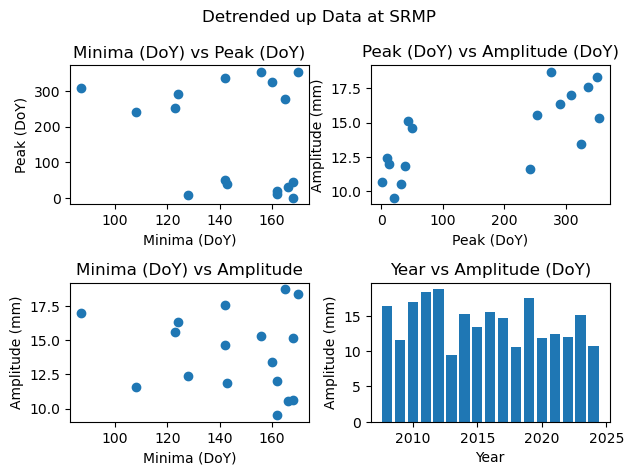

In [41]:
fig, axs = plt.subplots(2, 2)

axs[0,0].scatter(minima,peak)
axs[0,0].set_title('Minima (DoY) vs Peak (DoY)')
axs[0,0].set_xlabel('Minima (DoY)')
axs[0,0].set_ylabel('Peak (DoY)')

axs[1,0].scatter(minima,amplitude)
axs[1,0].set_title('Minima (DoY) vs Amplitude')
axs[1,0].set_ylabel('Amplitude (mm)')
axs[1,0].set_xlabel('Minima (DoY)')

axs[0,1].scatter(peak,amplitude)
axs[0,1].set_title('Peak (DoY) vs Amplitude (DoY)')
axs[0,1].set_ylabel('Amplitude (mm)')
axs[0,1].set_xlabel('Peak (DoY)')

years = np.arange(2008, 2025)
axs[1,1].bar(years,amplitude)
axs[1,1].set_title('Year vs Amplitude (DoY)')
axs[1,1].set_ylabel('Amplitude (mm)')
axs[1,1].set_xlabel('Year')

fig.suptitle('Detrended '+ Disp +' Data at ' + station_name)
fig.tight_layout()

## Comparision Tables
Amplitudes, Peak, Minima

And then Averaged

In [ ]:
peakval, minimaval, peak, minima, amplitude = [], [], [], [], []

years_used = []

for i, year in enumerate(np.unique(df_rolling.year)):
    data = df_rolling[df_rolling['year'] == str(year)]

    if data.shape[0] > 350:
        years_used.append(year)
        a = data[Disp].idxmin()
        minima.append(data['doy'][a])
        minimaval.append(data[Disp][a])

        b = data[Disp].idxmax()
        peak.append(data['doy'][b])
        peakval.append(data[Disp][b])

        a1 = data[Disp].min()
        b1 = data[Disp].max()
        amplitude.append(b1-a1)

peak = np.array(peak)
peakval = np.array(peakval)
minima = np.array(minima)
minimaval = np.array(minimaval)
amplitude = np.array(amplitude)

arr = np.vstack([peak, peakval, minima, minimaval, amplitude])

# ------- Circular Mean for DOY variables -------

# Compute averages
avg_peak_doy = circular_mean(peak)
avg_min_doy = circular_mean(minima)
avg_peak_val = np.mean(peakval)
avg_min_val = np.mean(minimaval)
avg_amp = np.mean(amplitude)

# Combine yearly data + average as a new column
arr = np.vstack([peak, peakval, minima, minimaval, amplitude])
avg_col = np.array([[avg_peak_doy], [avg_peak_val], [avg_min_doy], [avg_min_val], [avg_amp]])
arr = np.hstack([arr, avg_col])  # now arr.shape = (5, n_years + 1)

# Update year labels
years_used.append("Mean")

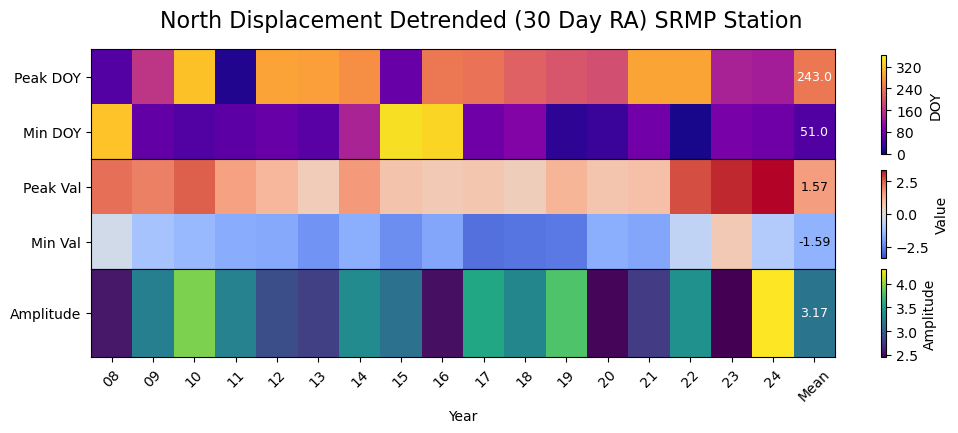

In [ ]:
# Prepare data and labels
row_labels = ['Peak DOY', 'Peak Value', 'Min DOY', 'Min Value', 'Amplitude']
years = np.unique(df_rolling.year)
years = [str(y) for y in years if df_rolling[df_rolling['year'] == str(y)].shape[0] > 350]

# Create figure with GridSpec for tight layout
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 0.8], hspace=0.0)

# ---- 1. DOY (Cyclical) ----
ax1 = fig.add_subplot(gs[0])
doy_data = np.vstack([arr[0], arr[2]])  # Peak DOY, Min DOY
im1 = ax1.imshow(doy_data, aspect='auto', cmap='plasma', vmin=0, vmax=365)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Peak DOY', 'Min DOY'])
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
cbar = fig.colorbar(im1, ax=ax1, orientation='vertical', label='DOY', shrink=0.9)
cbar.locator = MaxNLocator(nbins=5)
cbar.update_ticks()

for row_idx in range(doy_data.shape[0]):
    val = doy_data[row_idx, -1]
    ax1.text(doy_data.shape[1]-1, row_idx, f"{val:.1f}", ha='center', va='center', color='white', fontsize=9)

# ---- 2. Peak/Min Values ----
ax2 = fig.add_subplot(gs[1], sharex=ax1)
val_data = np.vstack([arr[1], arr[3]])  # Peak & Min Value

im2 = ax2.imshow(val_data, aspect='auto', cmap='coolwarm', vmin=-np.max(np.abs(val_data)), vmax=np.max(np.abs(val_data)))
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Peak Val', 'Min Val'])
ax2.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
fig.colorbar(im2, ax=ax2, orientation='vertical', label='Value', shrink=0.8)
for row_idx in range(val_data.shape[0]):
    val = val_data[row_idx, -1]
    ax2.text(val_data.shape[1]-1, row_idx, f"{val:.2f}", ha='center', va='center',
             color='black' if abs(val) < 10 else 'white', fontsize=9)

# ---- 3. Amplitude ----
ax3 = fig.add_subplot(gs[2], sharex=ax1)
amp_data = arr[4:5]  # Amplitude only

im3 = ax3.imshow(amp_data, aspect='auto', cmap='viridis', vmin=np.min(amp_data), vmax=np.max(amp_data))
ax3.set_yticks([0])
ax3.set_yticklabels(['Amplitude'])
ax3.set_xticks(np.arange(len(years_used)))
ax3.set_xticklabels(years_used, rotation=45)

cbar = fig.colorbar(im3, ax=ax3, orientation='vertical', label='Amplitude')
cbar.locator = MaxNLocator(nbins=4)
cbar.update_ticks()

val = amp_data[0, -1]
ax3.text(amp_data.shape[1]-1, 0, f"{val:.2f}", ha='center', va='center', color='white', fontsize=9)

# ---- Global formatting ----

fig.suptitle( "North Displacement Detrended (30 Day RA) SRMP Station", fontsize=16, y=0.98, x= 0.45)
ax3.set_xlabel("Year")

plt.show()

In [ ]:
all_station_averages = []  # Store avg arrays for each station
stations_processed = []

wdays = 30

for station_name in StationMetaData.station:
    try:
        st = StationMetaData[StationMetaData['station'] == str(station_name)]
        lat = st.latitude.values
        lon = st.longitude.values
        
        raw_data = get_data(station_name)
        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])

        # Find longest continuous segment of data
        continuous_segment = find_longest_continuous_segment(converted_dates, max_gap_days=MAX_GAP_DAYS)

        if len(continuous_segment) < 365 * 3:
            print(f"  → Skipping {station_name}: continuous segment too short.")
            continue

        # Filter both data and error to this segment
        mask = np.isin(converted_dates, continuous_segment)
        data = raw_data[mask, 1:4]
        error = raw_data[mask, 4:]
        converted_dates = converted_dates[mask]

        # Detrend data
        data_detrended = scipy.signal.detrend(data, axis=0)

        # Build DataFrame
        df = pd.DataFrame({'time': converted_dates})
        df['east'] = data_detrended[:, 0]
        df['north'] = data_detrended[:, 1]
        df['up'] = data_detrended[:, 2]
        df.set_index('time', inplace=True)
        df.index = pd.to_datetime(df.index)

        # Add DoY
        df['doy'] = df.index.dayofyear

        # Rolling mean
        df_rolling = df.rolling(window=wdays, center=True, min_periods=wdays).mean()
        df_rolling['year'] = df_rolling.index.year
        df_rolling = df_rolling.dropna()

        # Initialize metrics
        peakval, minimaval, peak, minima, amplitude = [], [], [], [], []
        years_used = []

        for year in np.unique(df_rolling['year']):
            data_year = df_rolling[df_rolling['year'] == year]

            if data_year.shape[0] > 350:
                years_used.append(year)
                min_idx = data_year[Disp].idxmin()
                max_idx = data_year[Disp].idxmax()

                minima.append(data_year['doy'][min_idx])
                minimaval.append(data_year[Disp][min_idx])

                peak.append(data_year['doy'][max_idx])
                peakval.append(data_year[Disp][max_idx])

                amp = data_year[Disp].max() - data_year[Disp].min()
                amplitude.append(amp)

        # Convert to arrays **once, after loop**
        peak = np.array(peak)
        peakval = np.array(peakval)
        minima = np.array(minima)
        minimaval = np.array(minimaval)
        amplitude = np.array(amplitude)

        # Compute averages
        avg_peak_doy = circular_mean(peak)
        avg_min_doy = circular_mean(minima)
        avg_peak_val = np.mean(peakval)
        avg_min_val = np.mean(minimaval)
        avg_amp = np.mean(amplitude)

        # Stack into a single array for this station
        avg_array = np.array([avg_peak_doy, avg_peak_val, avg_min_doy, avg_min_val, avg_amp, lat[0], lon[0]])
        all_station_averages.append(avg_array)
        stations_processed.append(station_name)


        #print(f"{station_name}: Avg Peak DOY = {avg_peak_doy:.1f}, Amplitude = {avg_amp:.2f}")

    except FileNotFoundError:
        print(f"  → File not found for station {station_name}. Skipping.")
        continue
    except Exception as e:
        print(f"  → Error processing station {station_name}: {e}")
        continue


  → Skipping NGFJ: continuous segment too short.
  → File not found for station THU4. Skipping.
  → File not found for station QENU. Skipping.
  → File not found for station AAS2. Skipping.
  → Skipping EQNU: continuous segment too short.
  → Skipping SCOB: continuous segment too short.
  → File not found for station SCO4. Skipping.
  → File not found for station STNO. Skipping.
  → File not found for station QAQ2. Skipping.
  → File not found for station KLQ3. Skipping.
  → Skipping UPAK: continuous segment too short.
  → Skipping AVAN: continuous segment too short.
  → Skipping THU1: continuous segment too short.
  → File not found for station THU3. Skipping.
  → Error processing station KSNB: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
  → Skipping NUNA: continuous segment too short.
  → Error processing station MIK2: setting an array element with a sequence. The reque

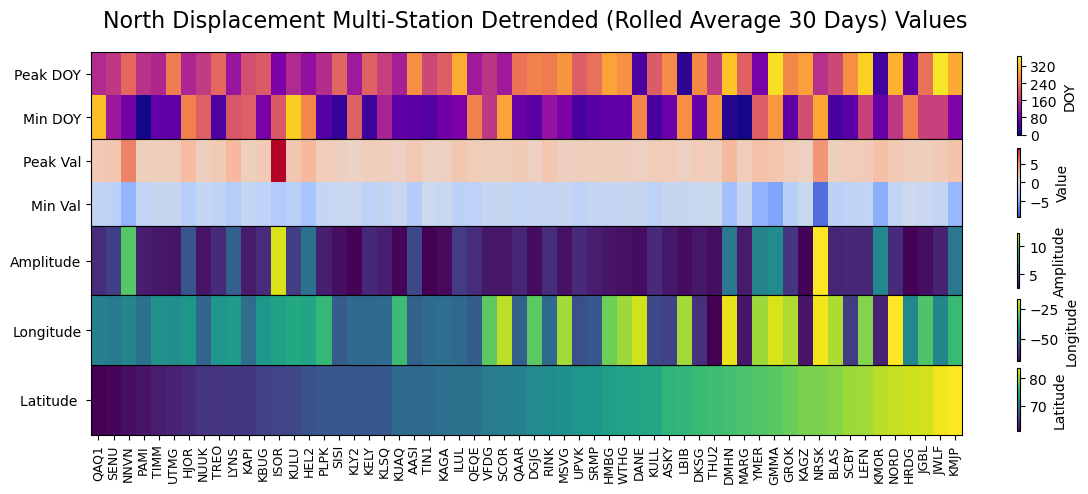

In [ ]:
arr = np.array(all_station_averages).T
row_labels = ['Peak DOY', 'Peak Value', 'Min DOY', 'Min Value', 'Amplitude', 'Latitude', 'Longitude']
stations = stations_processed

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 0.8, 0.8, 0.8], hspace=0.0)

latitudes = arr[5]
sorted_indices = np.argsort(latitudes)

# Step 2: Sort the array and stations
arr = arr[:, sorted_indices]
stations = [stations[i] for i in sorted_indices]

# ---- 1. DOY (Cyclical) ----
ax1 = fig.add_subplot(gs[0])
doy_data = arr[0:3:2]  # Peak DOY, Min DOY
im1 = ax1.imshow(doy_data, aspect='auto', cmap='plasma', vmin=0, vmax=365)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Peak DOY', 'Min DOY'])
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
cbar = fig.colorbar(im1, ax=ax1, orientation='vertical', label='DOY', shrink=0.9)
cbar.locator = MaxNLocator(nbins=5)
cbar.update_ticks()

# ---- 2. Peak/Min Values ----
ax2 = fig.add_subplot(gs[1], sharex=ax1)
val_data = arr[1:4:2]  # Peak Val, Min Val
im2 = ax2.imshow(val_data, aspect='auto', cmap='coolwarm', vmin=-np.max(np.abs(val_data)), vmax=np.max(np.abs(val_data)))
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Peak Val', 'Min Val'])
ax2.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
fig.colorbar(im2, ax=ax2, orientation='vertical', label='Value', shrink=0.8)


# ---- 3. Amplitude ----
ax3 = fig.add_subplot(gs[2], sharex=ax1)
amp_data = arr[4:5]  # Amplitude only
im3 = ax3.imshow(amp_data, aspect='auto', cmap='viridis', vmin=np.min(amp_data), vmax=np.max(amp_data))
ax3.set_yticks([0])
ax3.set_yticklabels(['Amplitude'])
ax3.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
fig.colorbar(im3, ax=ax3, orientation='vertical', label='Amplitude', shrink=0.8)

# ---- 3. Lat ----
ax4 = fig.add_subplot(gs[4], sharex=ax1)
lat_data = arr[5:6]  # Ampitude only
im4 = ax4.imshow(lat_data, aspect='auto', cmap='viridis')
ax4.set_yticks([0])
ax4.set_yticklabels(['Latitude '])

ax4.set_xticks(np.arange(len(stations)))
ax4.set_xticklabels(stations, rotation=90, fontsize=9)

fig.colorbar(im4, ax=ax4, orientation='vertical', label='Latitude', shrink = 0.9)

# ---- 3. Longitude ----
ax5 = fig.add_subplot(gs[3], sharex=ax1)
lon_data = arr[6:7]  # Amplitude only
im5 = ax5.imshow(lon_data, aspect='auto', cmap='viridis')
ax5.set_yticks([0])
ax5.set_yticklabels(['Longitude'])
ax5.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

fig.colorbar(im5, ax=ax5, orientation='vertical', label='Longitude', shrink = 0.9)

# ---- Global formatting ----
fig.suptitle("North Displacement Multi-Station Detrended (Rolled Average 30 Days) Values", fontsize=16, y=0.98, x=0.45)
ax3.set_xlabel("Station")

plt.tight_layout()
plt.show()


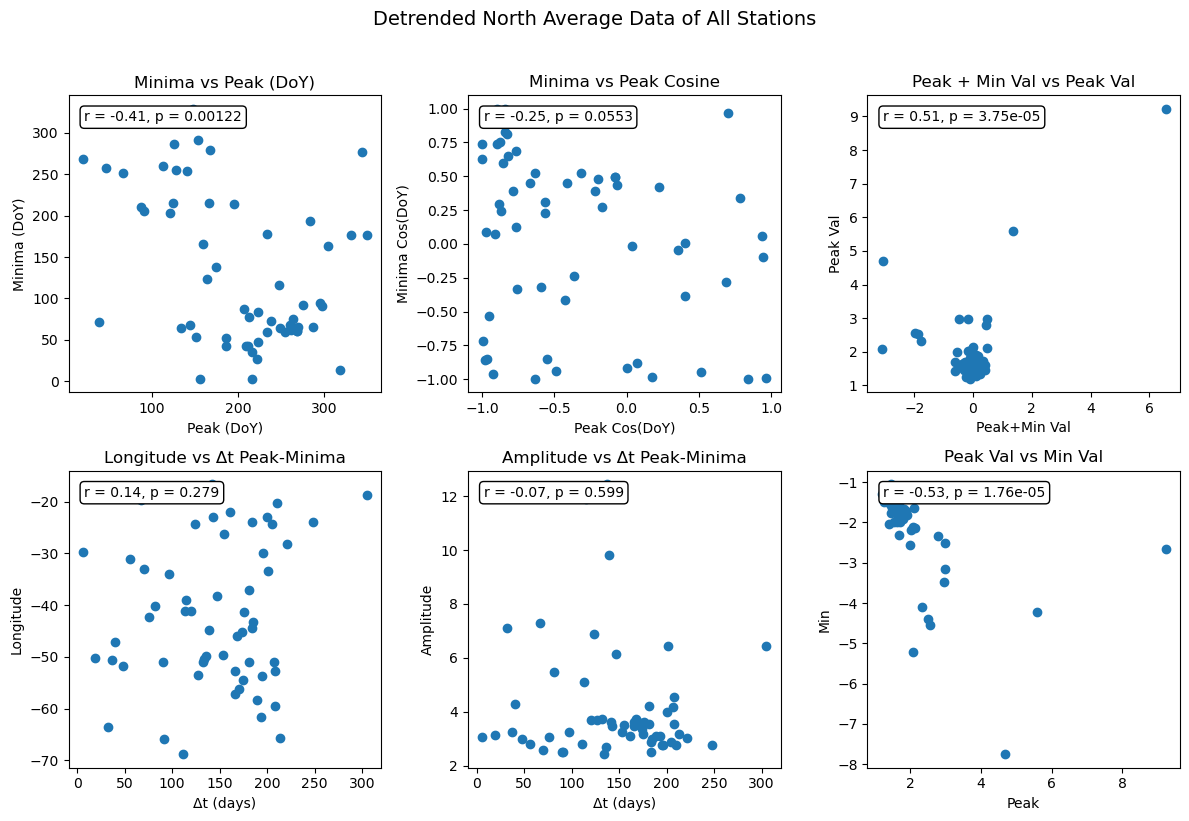

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example function (replace with your actual implementation)
def doy_to_angle(doy):
    return np.cos(2 * np.pi * doy / 365.0)

# Create the subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Subplot 1: Minima vs Peak (DoY)
x = doy_data[0, :]
y = doy_data[1, :]
r, p = pearsonr(x, y)
axs[0, 0].scatter(x, y)
axs[0, 0].set_title('Minima vs Peak (DoY)')
axs[0, 0].set_xlabel('Peak (DoY)')
axs[0, 0].set_ylabel('Minima (DoY)')
axs[0, 0].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))

# Subplot 2: Minima vs Peak Cosine
x = [doy_to_angle(d) for d in doy_data[0, :]]
y = [doy_to_angle(d) for d in doy_data[1, :]]
r, p = pearsonr(x, y)
axs[0, 1].scatter(x, y)
axs[0, 1].set_title('Minima vs Peak Cosine')
axs[0, 1].set_xlabel('Peak Cos(DoY)')
axs[0, 1].set_ylabel('Minima Cos(DoY)')
axs[0, 1].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))

# Subplot 3: Latitude vs Δt Peak-Minima
x = np.abs(doy_data[0, :] - doy_data[1, :])
y = lon_data[0]
r, p = pearsonr(x, y)
axs[1, 0].scatter(x, y)
axs[1, 0].set_title('Longitude vs Δt Peak-Minima')
axs[1, 0].set_xlabel('Δt (days)')
axs[1, 0].set_ylabel('Longitude')
axs[1, 0].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))

# Subplot 4: Amplitude vs Δt Peak-Minima
x = np.abs(doy_data[0, :] - doy_data[1, :])
y = amp_data[0]
r, p = pearsonr(x, y)
axs[1, 1].scatter(x, y)
axs[1, 1].set_title('Amplitude vs Δt Peak-Minima')
axs[1, 1].set_xlabel('Δt (days)')
axs[1, 1].set_ylabel('Amplitude')
axs[1, 1].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))

#S5
x = val_data[0] + val_data[1]
y = val_data[0]
r, p = pearsonr(x, y)
axs[0, 2].scatter(x, y)
axs[0, 2].set_title('Peak + Min Val vs Peak Val')
axs[0, 2].set_xlabel('Peak+Min Val')
axs[0, 2].set_ylabel('Peak Val')
axs[0, 2].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))
#S6 
x = val_data[0]
y = val_data[1]
r, p = pearsonr(x, y)
axs[1, 2].scatter(x, y)
axs[1, 2].set_title('Peak Val vs Min Val')
axs[1, 2].set_xlabel('Peak')
axs[1, 2].set_ylabel('Min')
axs[1, 2].annotate(f'r = {r:.2f}, p = {p:.3g}', xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))
# Add main title and adjust layout
fig.suptitle('Detrended North Average Data of All Stations', fontsize=14, y=1.02)
fig.tight_layout()
plt.show()


## Grace Data

In [ ]:
Grace = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/SRMPGrace.csv')
Grace

In [ ]:
Grace = Grace.set_index('DateTime')
Grace

In [ ]:
GraceSamePeriod = Grace.loc['2007-09':'2025-02']
GraceSamePeriod

data_detrended = scipy.signal.detrend(GraceSamePeriod, axis=0)

# Build DataFrame
df = pd.DataFrame({'time': GraceSamePeriod.index})
df['grace'] = data_detrended
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)
df['month'] = df.index.strftime('%m')

ltmgrace = df.groupby('month')['grace'].mean()
ltmgrace

In [ ]:
plt.bar(ltmgrace.index,ltmgrace)
plt.title("Detrended Grace Water Equivalent Thickness")
plt.xlabel('Month')
plt.ylabel('Water Equivalent Thickness (m)')